In [1]:
import numpy as np
import torch
import pyepo

# set random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
num_node = 20 # node size
num_data = 1000 # number of training data
num_feat = 10 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.tsp.genData(num_data+100+1000, num_feat, num_node, deg, e, seed=42)

In [3]:
from model import tspDFJModel
# set solver
optmodel = tspDFJModel(num_node)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
tour = optmodel.getTour(sol)
print(" -> ".join(map(str, tour)))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-01
Obj: 58.1424
0 -> 10 -> 15 -> 8 -> 5 -> 3 -> 17 -> 1 -> 6 -> 13 -> 19 -> 11 -> 18 -> 7 -> 2 -> 14 -> 12 -> 4 -> 9 -> 16 -> 0


In [4]:
# split data
from sklearn.model_selection import train_test_split
feats, x_test, costs, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)
x_train, x_val, c_train, c_val = train_test_split(feats, costs, test_size=100, random_state=42)

In [5]:
# get training, validation and test dataset
dataset_train_cost = pyepo.data.dataset.optDataset(optmodel, x_train, costs=c_train)
dataset_val = pyepo.data.dataset.optDataset(optmodel, x_val, costs=c_val)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 134.74it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 145.08it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 119.73it/s]


In [6]:
from dataset import optDatasetConstrs
dataset_train = optDatasetConstrs(optmodel, x_train, costs=c_train)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 54.51it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
from dataset import collate_fn
batch_size = 32
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_train = DataLoader(dataset_train, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, num_node*(num_node-1)//2)

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt

def plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Loss Curve on Training Set", fontsize=36)
    plt.show()
    # draw grad plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(grad_log, color="g", alpha=0.5, lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.gca().yaxis.get_offset_text().set_size(24)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Abs Grad", fontsize=36)
    plt.title("Absolute Gradient Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    fig = plt.figure(figsize=(16, 8))
    plt.plot([i * log_step for i in range(len(regret_log_trn))], regret_log_trn,
             color="royalblue", ls="--", alpha=0.7, lw=5, label="Train")
    plt.plot([i * log_step for i in range(len(regret_log_val))], regret_log_val,
             color="lightcoral", ls=":", alpha=0.7, lw=5, label="Val")
    plt.xlim(-0.5, num_epochs+0.5)
    plt.ylim(0, 0.5)
    plt.xticks(range(0, num_epochs+1, 5), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.legend(fontsize=32)
    plt.title("Regret Curve on Training and Validation Set", fontsize=36)
    plt.show()

## Train

In [10]:
num_epochs = 20
log_step = 1

In [11]:
import copy
import time
from tqdm import tqdm
import torch.nn.functional as F

from earlystop import earlyStopper
from clipgrad import clipGrad

def pipeline(reg, forward_func, loss_func, lr, num_epochs, 
             log_step, loader_train, loader_val, loader_test, grad_clip=False, seed=42):
    # set random seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # set stopper
    stopper = earlyStopper(patience=3)
    stop = False
    # init best model
    best_model_state = copy.deepcopy(reg.state_dict())
    best_val_regret = float("inf")
    # init log
    loss_log = []
    grad_log = []
    regret_log_trn = []
    regret_log_val = []
    # running time
    elapsed = 0
    tbar = tqdm(range(num_epochs))
    for epoch in tbar:
        # eval & log
        if epoch % log_step == 0:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_log_trn.append(regret_trn)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
            regret_log_val.append(regret_val)
            tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".format(epoch, regret_trn*100, regret_val*100))
            # update best model
            if regret_val < best_val_regret:
                best_val_regret = regret_val
                best_model_state = copy.deepcopy(reg.state_dict())
            # early stop
            if stopper.stop(regret_val):
                print()
                stop = True
                print("Early Stop!")
                break
        # training
        time.sleep(1)
        tick = time.time()
        for data in loader_train:
            # forward pass
            loss = forward_func(data, reg, loss_func, grad_log)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # clip
            if grad_clip:
                clipGrad(reg, threshold=1e-6)
            optimizer.step()
            loss_log.append(loss.item())
            tbar.set_description("Epoch {:4.0f}, Loss: {:8.4f}".format(epoch, loss.item()))
        # record time
        tock = time.time()
        elapsed += tock - tick
    # no early stop
    if not stop:
        regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
        regret_log_trn.append(regret_trn)
        regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
        regret_log_val.append(regret_val)
        tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".format(epoch, regret_trn*100, regret_val*100))
    # restore best model
    reg.load_state_dict(best_model_state)
    print()
    print("Evaluation:")
    test_regret = pyepo.metric.regret(reg, optmodel, loader_test)
    print("Test Regret: {:.4f}%".format(test_regret*100))
    print("Training Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, grad_log, regret_log_trn, regret_log_val

def forwardCAVE(data, reg, loss_func, grad_log, reg_lambda=1e-2):
    # unzip data
    x, c, _, t_ctr = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, t_ctr) + reg_lambda * F.mse_loss(cp, c)
    return loss

### Exact Method with Clarabel

In [12]:
# init model
reg = LinearRegression()

In [13]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, solver="clarabel", processes=8)

(CVXPY) Dec 03 10:29:30 PM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')
Num of cores: 8


In [14]:
lr = 1e-1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:10<?, ?it/s]

Epoch   0, Train Regret: 216.6579%, Val Regret: 224.0108%


Epoch    0, Loss:  -0.7465:   5%|██▊                                                    | 1/20 [00:40<09:21, 29.56s/it]

Epoch   1, Train Regret:  13.3203%, Val Regret:  14.5007%


Epoch    1, Loss:  -0.8908:  10%|█████▌                                                 | 2/20 [01:00<07:33, 25.21s/it]

Epoch   2, Train Regret:  14.4619%, Val Regret:  14.4818%


Epoch    2, Loss:  -0.8418:  15%|████████▎                                              | 3/20 [01:22<06:33, 23.16s/it]

Epoch   3, Train Regret:  13.3648%, Val Regret:  13.7928%


Epoch    3, Loss:  -0.8219:  20%|███████████                                            | 4/20 [01:42<05:59, 22.48s/it]

Epoch   4, Train Regret:  12.5238%, Val Regret:  12.3615%


Epoch    4, Loss:  -0.9280:  25%|█████████████▊                                         | 5/20 [02:04<05:28, 21.91s/it]

Epoch   5, Train Regret:  12.0830%, Val Regret:  12.7485%


Epoch    5, Loss:  -0.8861:  30%|████████████████▌                                      | 6/20 [02:24<04:59, 21.38s/it]

Epoch   6, Train Regret:  12.0955%, Val Regret:  11.7019%


Epoch    6, Loss:  -0.9028:  35%|███████████████████▎                                   | 7/20 [02:43<04:28, 20.69s/it]

Epoch   7, Train Regret:  11.8385%, Val Regret:  12.4026%


Epoch    7, Loss:  -0.9389:  40%|██████████████████████                                 | 8/20 [03:02<04:02, 20.23s/it]

Epoch   8, Train Regret:  12.0660%, Val Regret:  12.1621%


Epoch    8, Loss:  -0.9070:  45%|████████████████████████▊                              | 9/20 [03:22<04:08, 22.55s/it]


Epoch   9, Train Regret:  11.9888%, Val Regret:  12.0884%

Early Stop!

Evaluation:
Test Regret: 12.4149%
Training Elapsed Time: 97.54 Sec


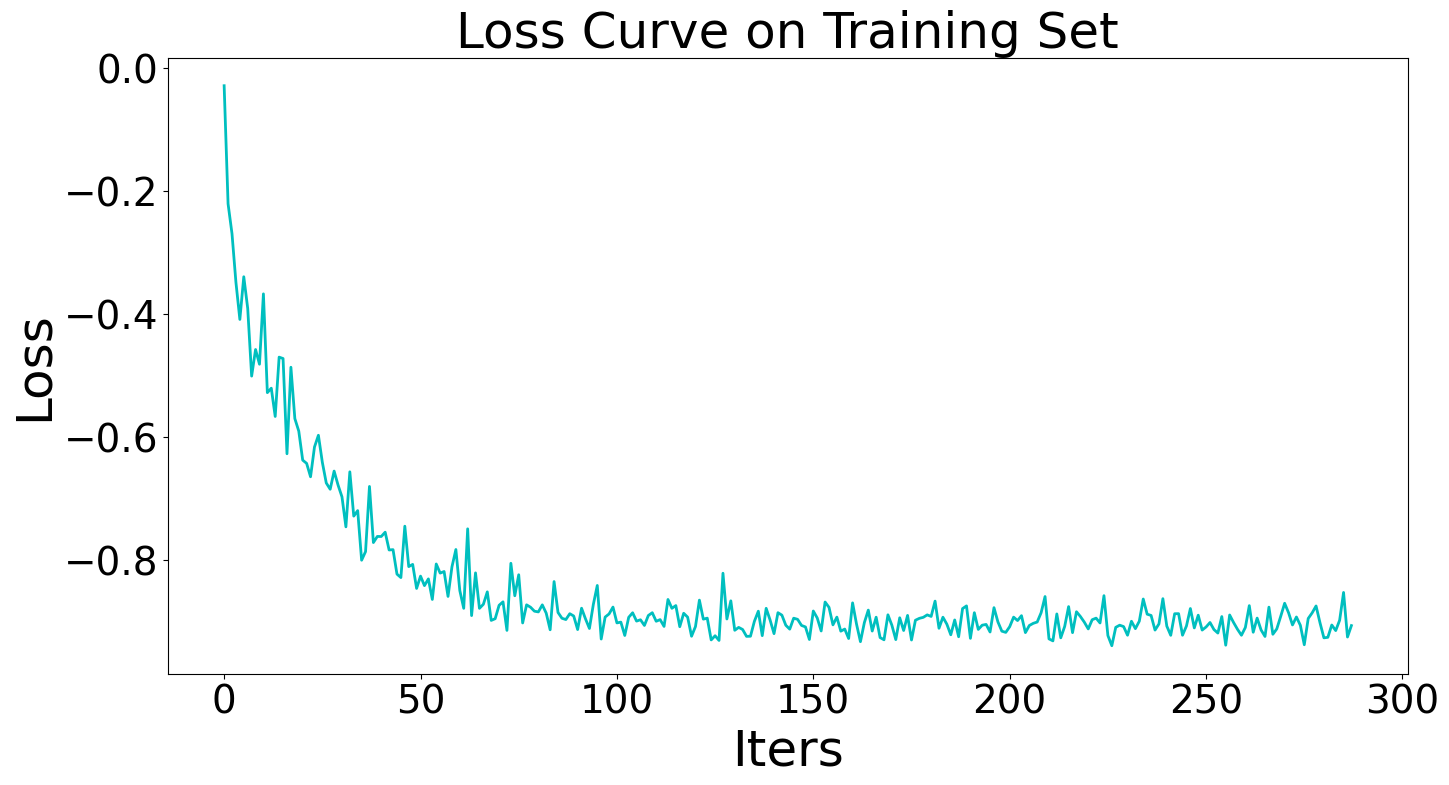

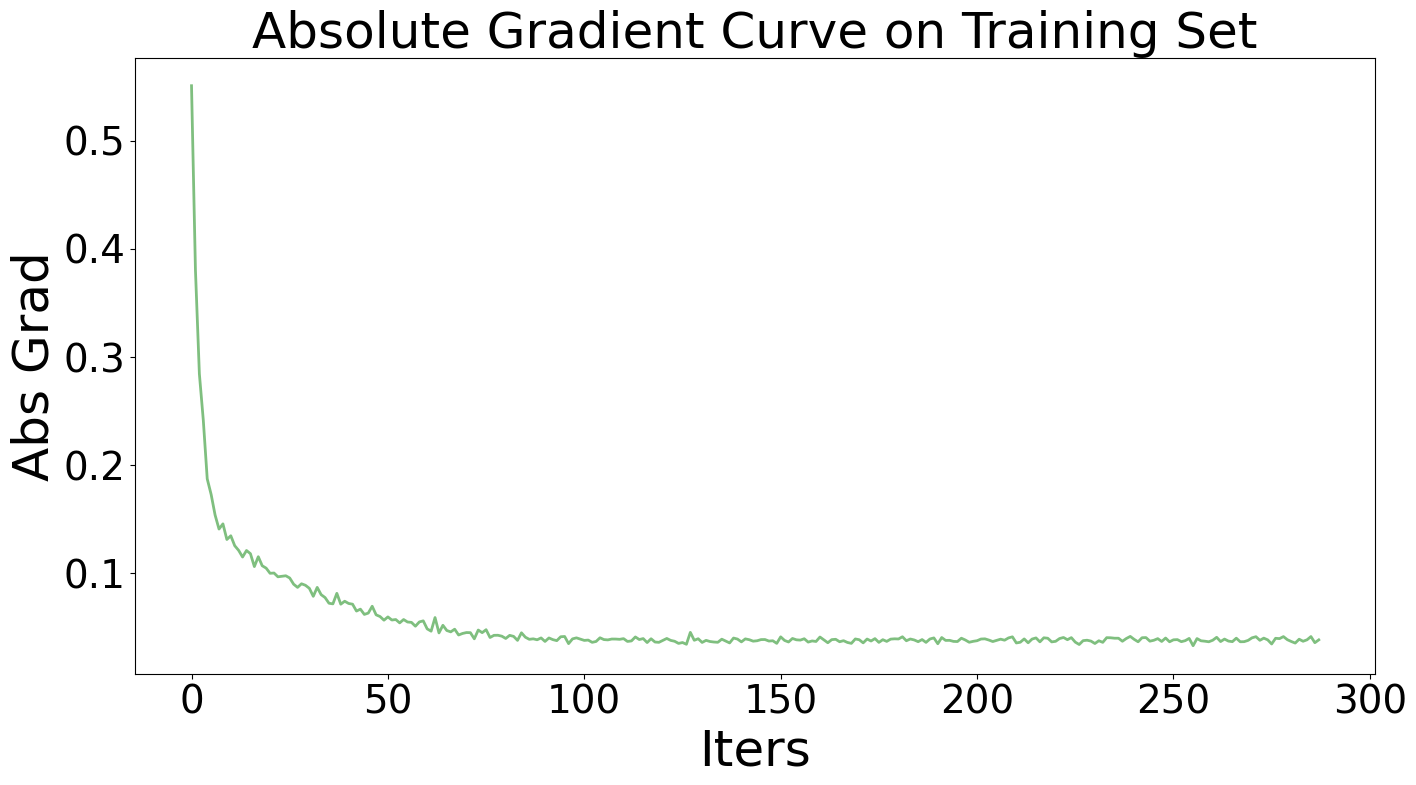

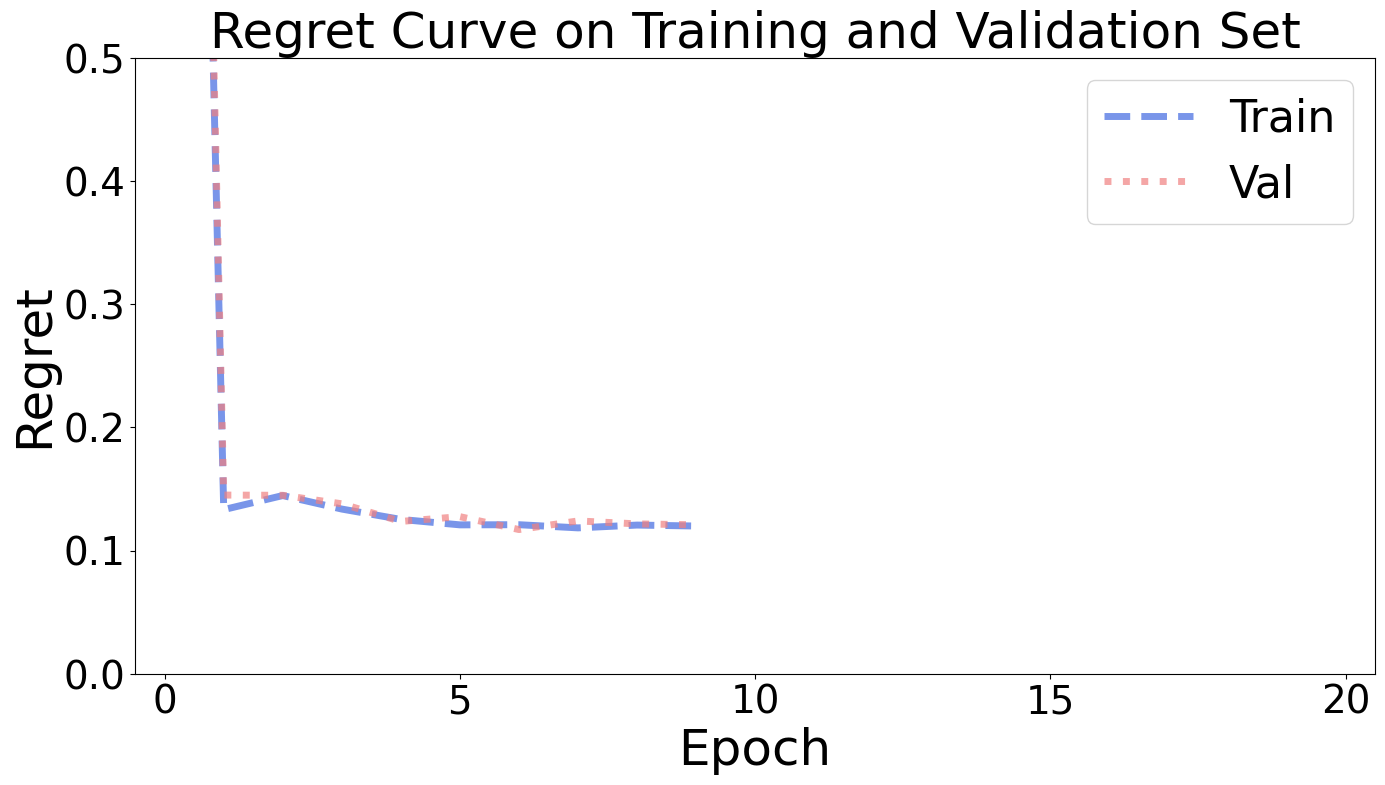

In [15]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Inner Method with Clarabel

In [16]:
# init model
reg = LinearRegression()

In [17]:
from func import innerConeAlignedCosine
# init loss
ca_cos = innerConeAlignedCosine(optmodel, solver="clarabel", processes=8)

Num of cores: 8


In [18]:
lr = 1e-1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:09<?, ?it/s]

Epoch   0, Train Regret: 210.3350%, Val Regret: 211.7011%


Epoch    0, Loss:  -0.7560:   5%|██▊                                                    | 1/20 [00:31<06:36, 20.87s/it]

Epoch   1, Train Regret:  13.6818%, Val Regret:  13.4624%


Epoch    1, Loss:  -0.8911:  10%|█████▌                                                 | 2/20 [00:50<06:15, 20.84s/it]

Epoch   2, Train Regret:  14.7135%, Val Regret:  15.7966%


Epoch    2, Loss:  -0.8422:  15%|████████▎                                              | 3/20 [01:10<05:40, 20.02s/it]

Epoch   3, Train Regret:  13.4761%, Val Regret:  13.9622%


Epoch    3, Loss:  -0.8218:  20%|███████████                                            | 4/20 [01:29<05:20, 20.02s/it]

Epoch   4, Train Regret:  12.2927%, Val Regret:  12.8247%


Epoch    4, Loss:  -0.9278:  25%|█████████████▊                                         | 5/20 [01:50<05:03, 20.24s/it]

Epoch   5, Train Regret:  11.8723%, Val Regret:  12.3486%


Epoch    5, Loss:  -0.8861:  30%|████████████████▌                                      | 6/20 [02:11<04:45, 20.39s/it]

Epoch   6, Train Regret:  11.6401%, Val Regret:  11.3665%


Epoch    6, Loss:  -0.9027:  35%|███████████████████▎                                   | 7/20 [02:32<04:26, 20.50s/it]

Epoch   7, Train Regret:  11.6226%, Val Regret:  12.0293%


Epoch    7, Loss:  -0.9386:  40%|██████████████████████                                 | 8/20 [02:54<04:12, 21.00s/it]

Epoch   8, Train Regret:  11.7701%, Val Regret:  11.8163%


Epoch    8, Loss:  -0.9068:  45%|████████████████████████▊                              | 9/20 [03:14<03:58, 21.64s/it]


Epoch   9, Train Regret:  11.6418%, Val Regret:  11.6912%

Early Stop!

Evaluation:
Test Regret: 12.1208%
Training Elapsed Time: 91.65 Sec


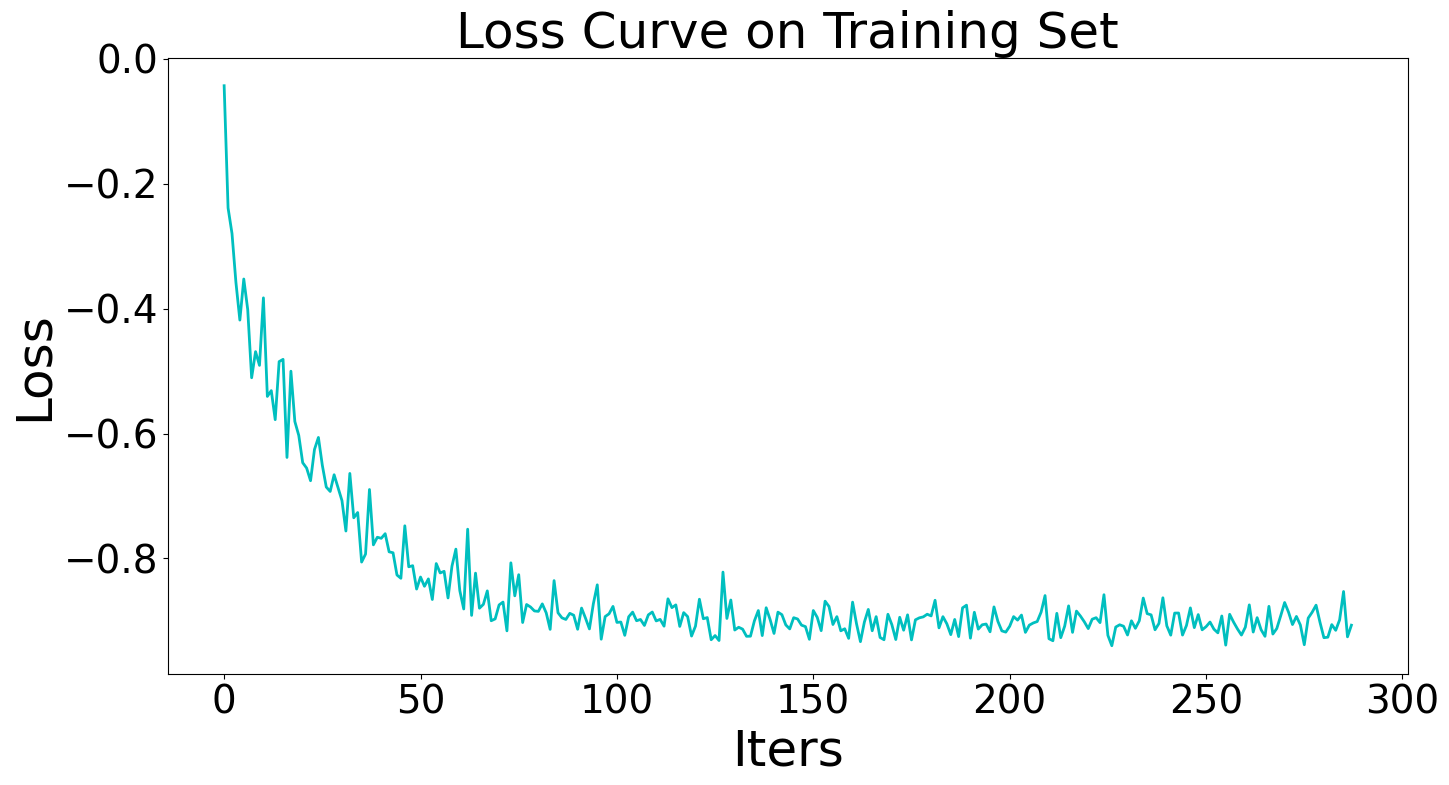

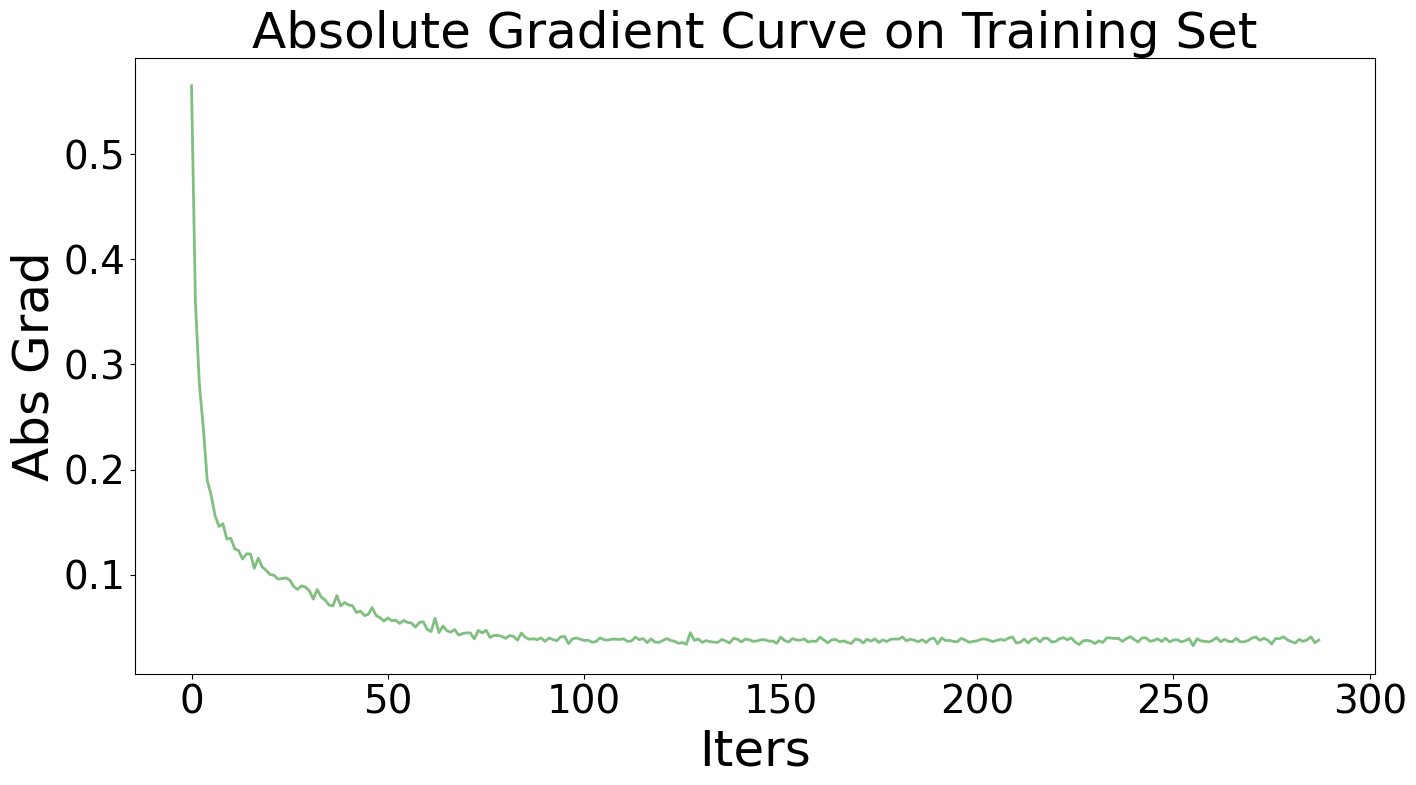

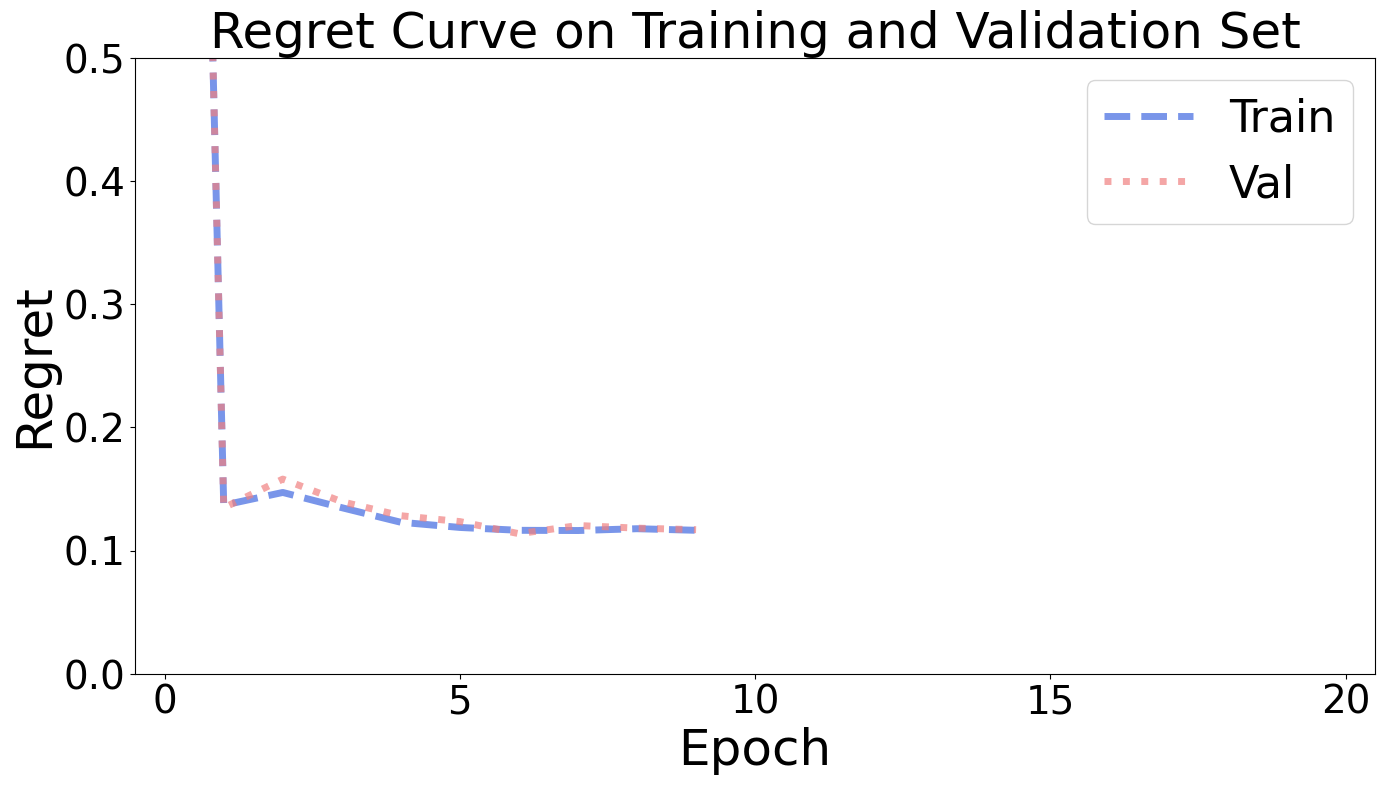

In [19]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sampling Method

In [20]:
# init model
reg = LinearRegression()

In [21]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100)

Num of cores: 1


In [22]:
lr = 1e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:09<?, ?it/s]

Epoch   0, Train Regret: 210.3350%, Val Regret: 211.7011%


Epoch    0, Loss:  -0.0526:   5%|██▊                                                    | 1/20 [00:20<03:30, 11.10s/it]

Epoch   1, Train Regret:  58.4939%, Val Regret:  60.8779%


Epoch    1, Loss:  -0.2428:  10%|█████▌                                                 | 2/20 [00:31<03:17, 11.00s/it]

Epoch   2, Train Regret:  11.7406%, Val Regret:  11.9595%


Epoch    2, Loss:  -0.2993:  15%|████████▎                                              | 3/20 [00:42<03:05, 10.91s/it]

Epoch   3, Train Regret:  10.7855%, Val Regret:  10.1469%


Epoch    3, Loss:  -0.2002:  20%|███████████                                            | 4/20 [00:53<02:55, 10.98s/it]

Epoch   4, Train Regret:   9.7623%, Val Regret:   9.9294%


Epoch    4, Loss:  -0.2236:  25%|█████████████▊                                         | 5/20 [01:05<02:45, 11.06s/it]

Epoch   5, Train Regret:   9.4136%, Val Regret:   8.9769%


Epoch    5, Loss:  -0.0650:  30%|████████████████▌                                      | 6/20 [01:17<02:41, 11.54s/it]

Epoch   6, Train Regret:   8.9997%, Val Regret:   9.6195%


Epoch    6, Loss:  -0.3826:  35%|███████████████████▎                                   | 7/20 [01:29<02:31, 11.68s/it]

Epoch   7, Train Regret:   8.8949%, Val Regret:  10.3557%


Epoch    7, Loss:  -0.3559:  40%|██████████████████████                                 | 8/20 [01:40<02:30, 12.55s/it]


Epoch   8, Train Regret:   8.8153%, Val Regret:   9.0279%

Early Stop!

Evaluation:
Test Regret: 10.1621%
Training Elapsed Time: 5.62 Sec


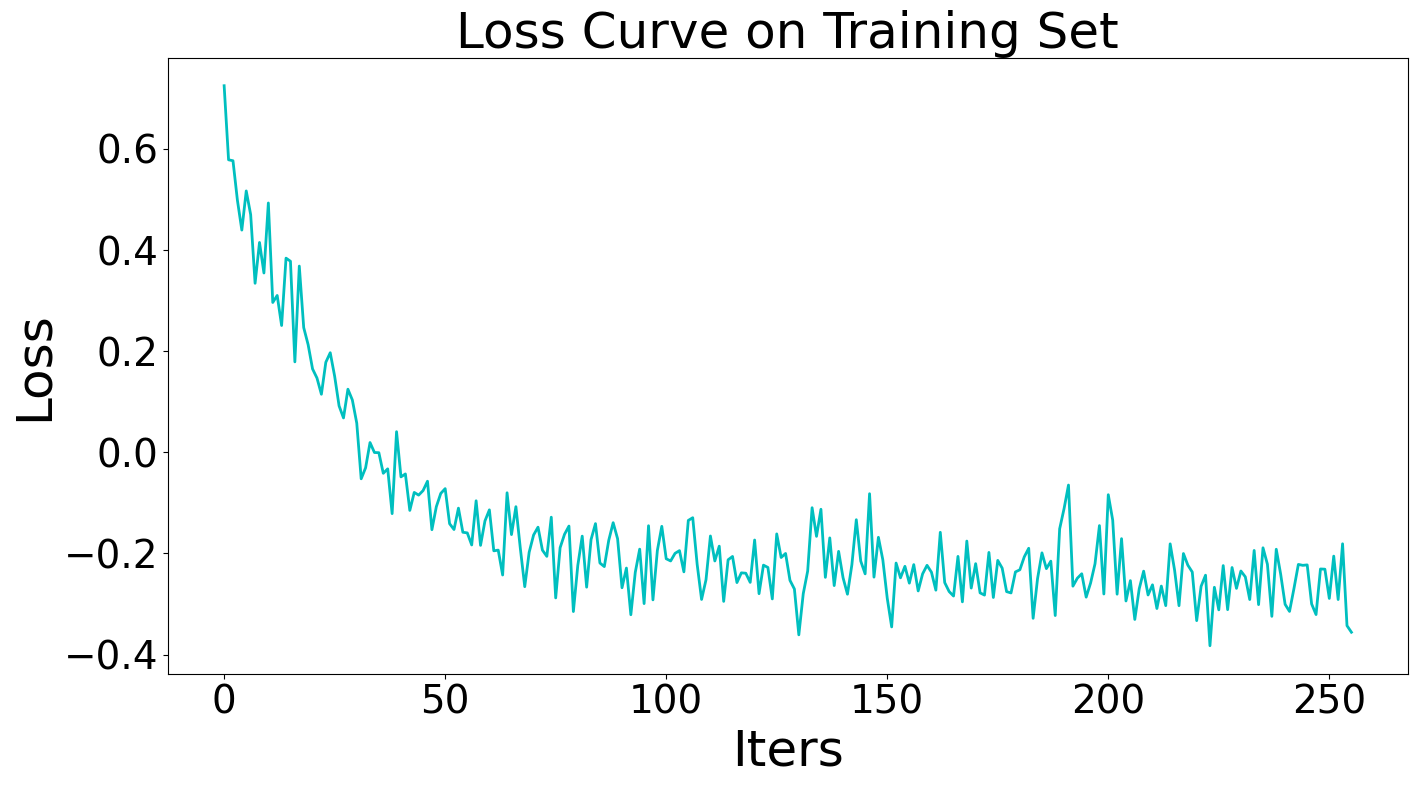

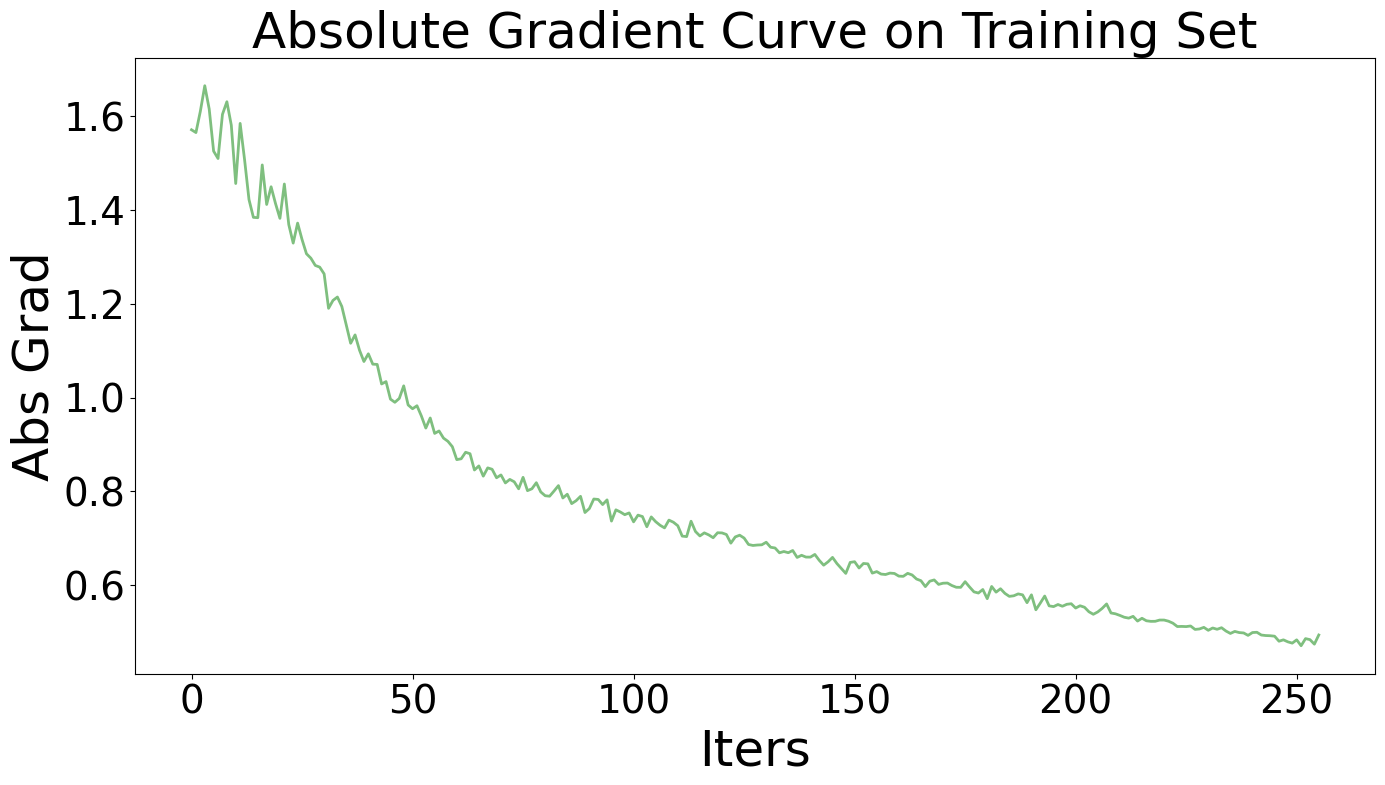

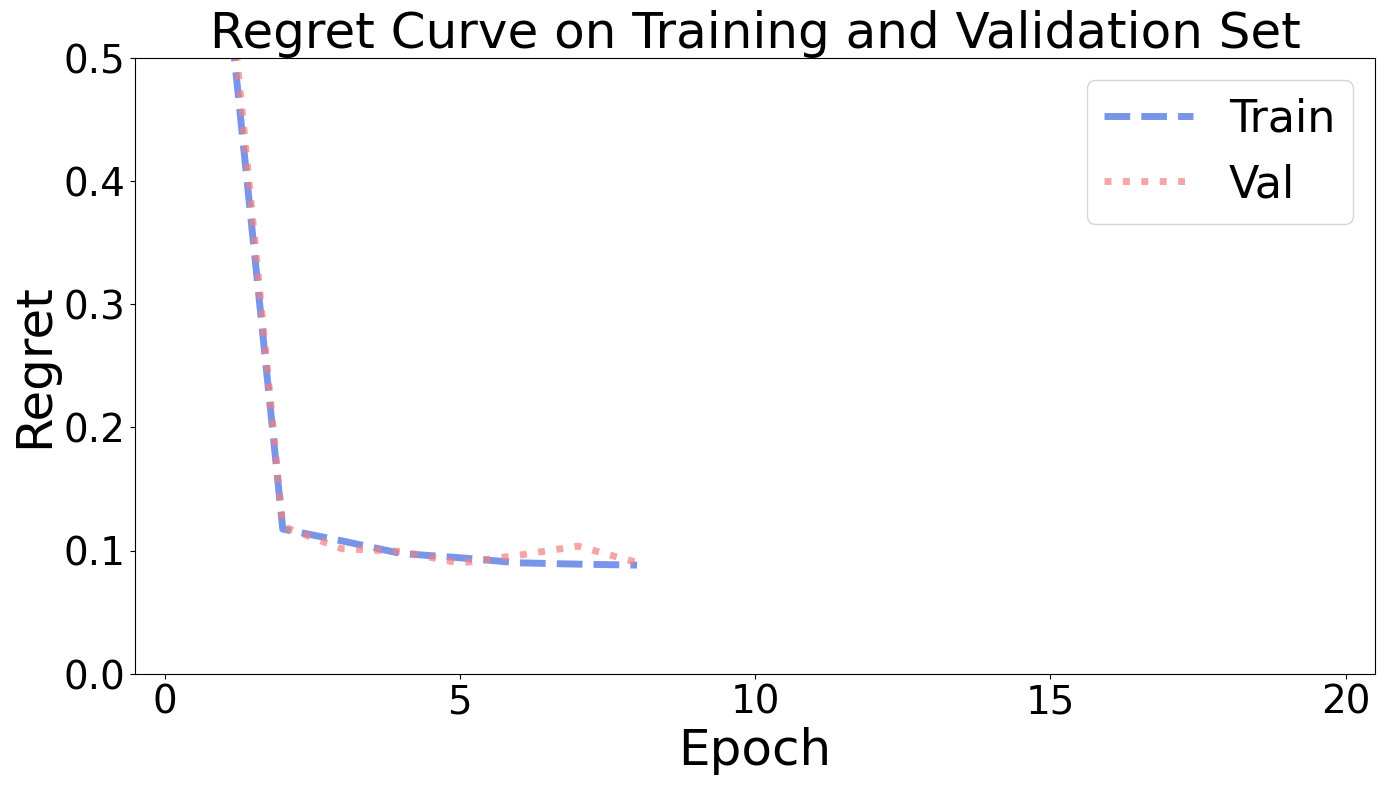

In [23]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sampling Method with Cone Check

In [24]:
# init model
reg = LinearRegression()

In [25]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100, check_cone=True)

Num of cores: 1


In [26]:
lr = 1e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:09<?, ?it/s]

Epoch   0, Train Regret: 204.1114%, Val Regret: 217.7248%


Epoch    0, Loss:   0.0040:   5%|██▊                                                    | 1/20 [00:23<04:34, 14.44s/it]

Epoch   1, Train Regret:  60.7325%, Val Regret:  62.7702%


Epoch    1, Loss:  -0.2310:  10%|█████▌                                                 | 2/20 [00:38<04:18, 14.38s/it]

Epoch   2, Train Regret:  12.1699%, Val Regret:  12.1667%


Epoch    2, Loss:  -0.2969:  15%|████████▎                                              | 3/20 [00:52<04:06, 14.49s/it]

Epoch   3, Train Regret:  10.9571%, Val Regret:  10.7776%


Epoch    3, Loss:  -0.2007:  20%|███████████                                            | 4/20 [01:07<03:51, 14.50s/it]

Epoch   4, Train Regret:   9.8549%, Val Regret:   9.0118%


Epoch    4, Loss:  -0.2237:  25%|█████████████▊                                         | 5/20 [01:23<03:40, 14.72s/it]

Epoch   5, Train Regret:   9.4793%, Val Regret:   9.1983%


Epoch    5, Loss:  -0.0642:  30%|████████████████▌                                      | 6/20 [01:38<03:31, 15.13s/it]

Epoch   6, Train Regret:   9.1940%, Val Regret:   9.0640%


Epoch    6, Loss:  -0.3812:  35%|███████████████████▎                                   | 7/20 [01:52<03:29, 16.12s/it]


Epoch   7, Train Regret:   8.7070%, Val Regret:   9.7410%

Early Stop!

Evaluation:
Test Regret: 10.2261%
Training Elapsed Time: 27.77 Sec


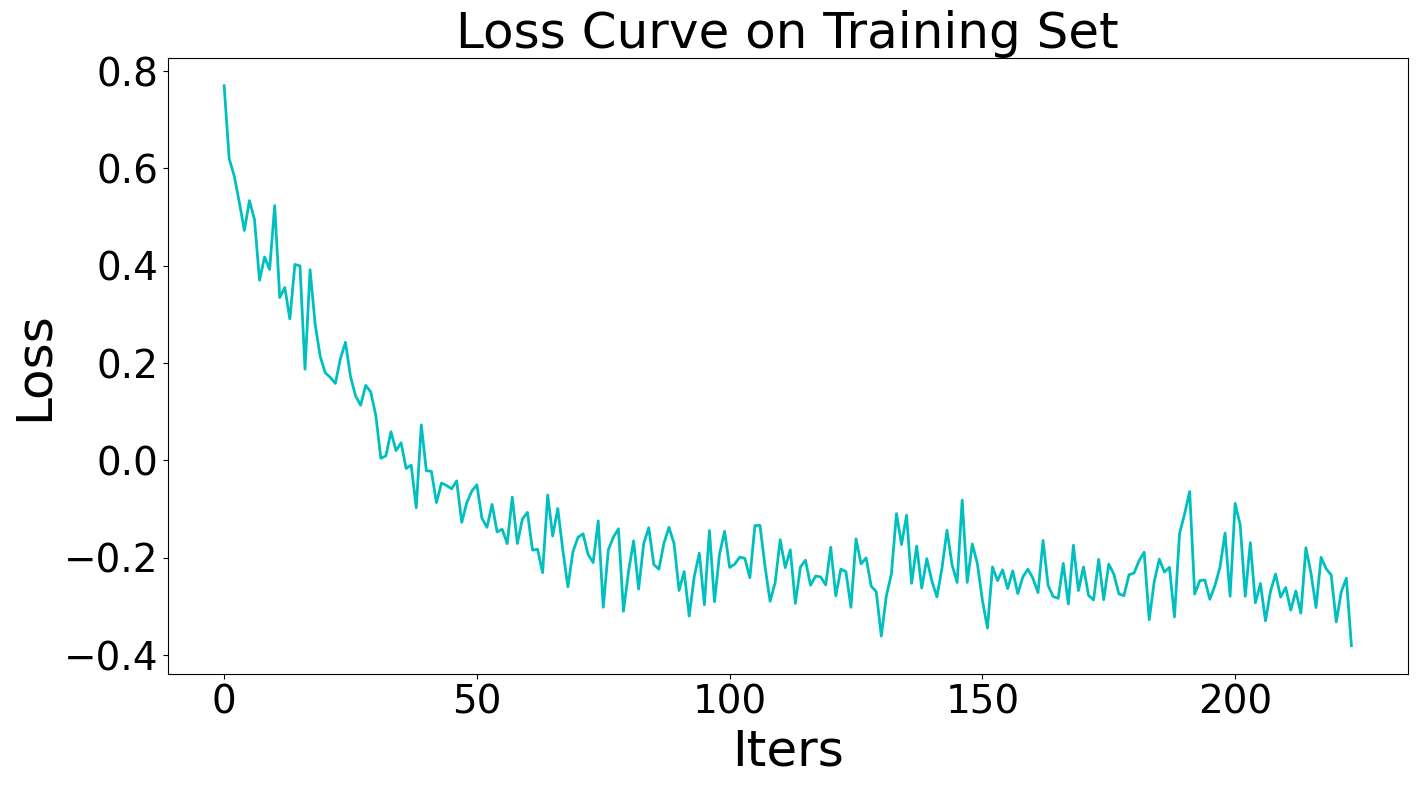

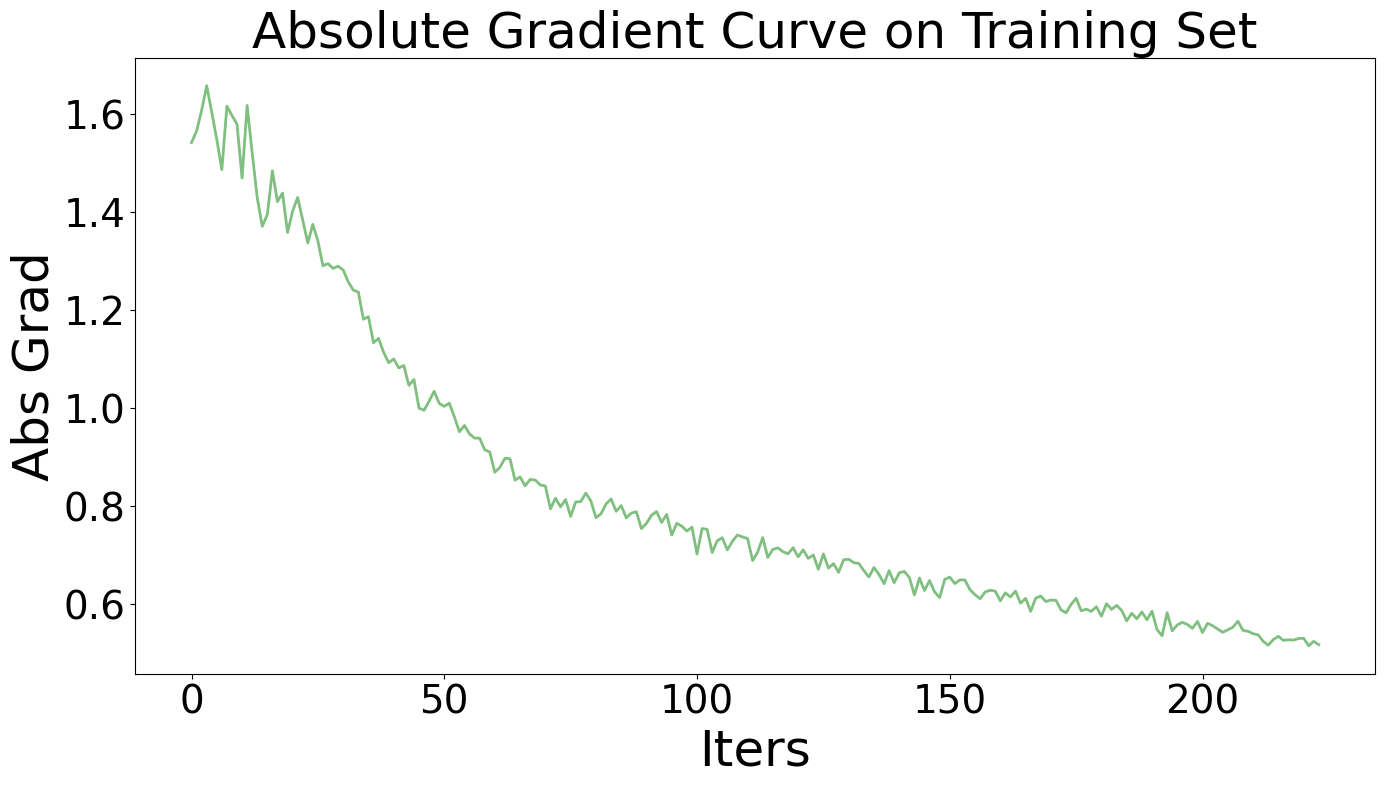

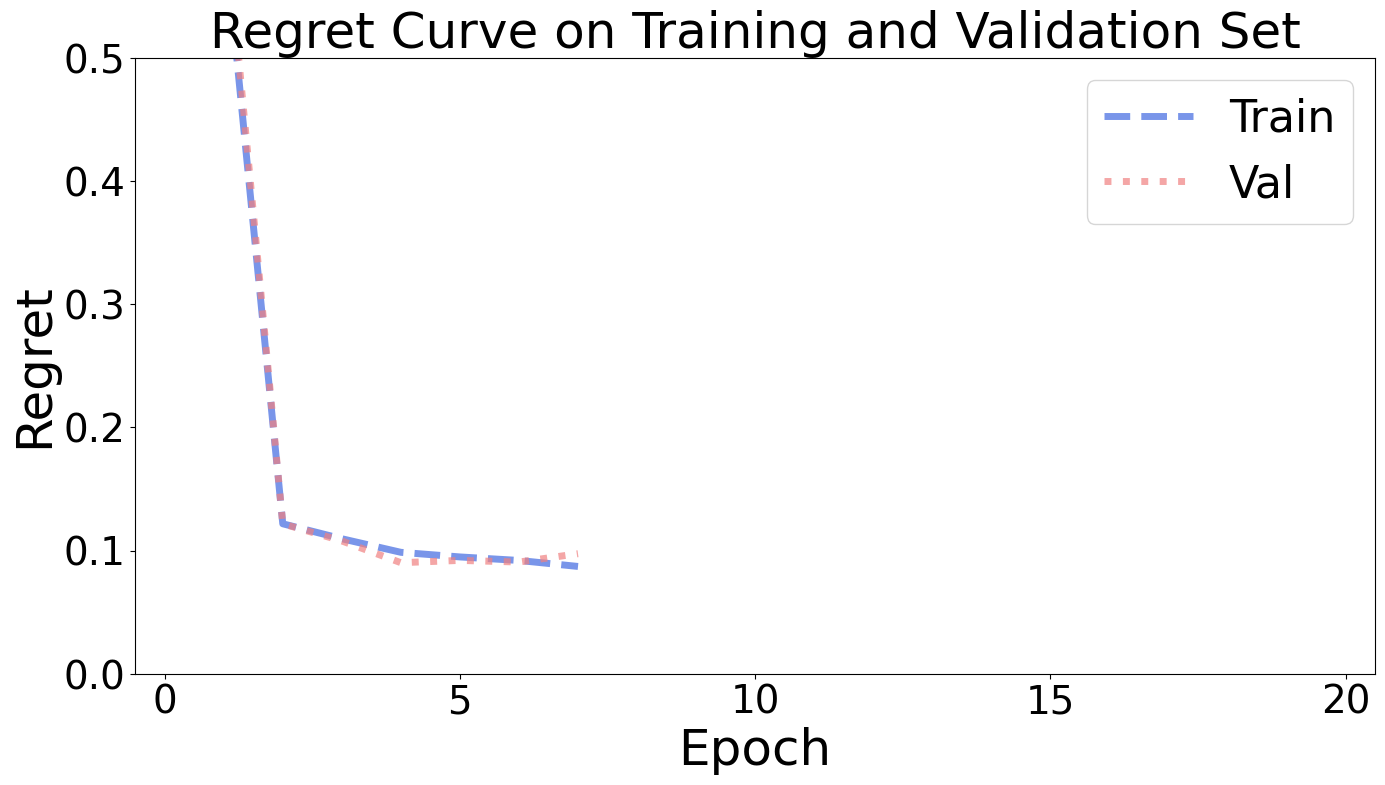

In [27]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Average Method 

In [28]:
# init model
reg = LinearRegression()

In [29]:
from func import avgConeAlignedCosine
# init loss
ca_cos = avgConeAlignedCosine(optmodel)

Num of cores: 1


In [30]:
lr = 1e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:09<?, ?it/s]

Epoch   0, Train Regret: 201.6410%, Val Regret: 214.9158%


Epoch    0, Loss:  -0.0551:   5%|██▊                                                    | 1/20 [00:19<03:20, 10.57s/it]

Epoch   1, Train Regret:  55.8444%, Val Regret:  56.3822%


Epoch    1, Loss:  -0.2818:  10%|█████▌                                                 | 2/20 [00:30<03:09, 10.54s/it]

Epoch   2, Train Regret:  11.3705%, Val Regret:  10.9695%


Epoch    2, Loss:  -0.1459:  15%|████████▎                                              | 3/20 [00:41<03:01, 10.67s/it]

Epoch   3, Train Regret:  10.1928%, Val Regret:   9.8571%


Epoch    3, Loss:  -0.1181:  20%|███████████                                            | 4/20 [00:52<02:53, 10.82s/it]

Epoch   4, Train Regret:  10.0310%, Val Regret:  10.1602%


Epoch    4, Loss:  -0.3359:  25%|█████████████▊                                         | 5/20 [01:03<02:43, 10.88s/it]

Epoch   5, Train Regret:   9.7982%, Val Regret:  10.3768%


Epoch    5, Loss:  -0.2257:  30%|████████████████▌                                      | 6/20 [01:15<02:56, 12.61s/it]


Epoch   6, Train Regret:   9.6724%, Val Regret:  10.2342%

Early Stop!

Evaluation:
Test Regret: 10.9656%
Training Elapsed Time: 1.52 Sec


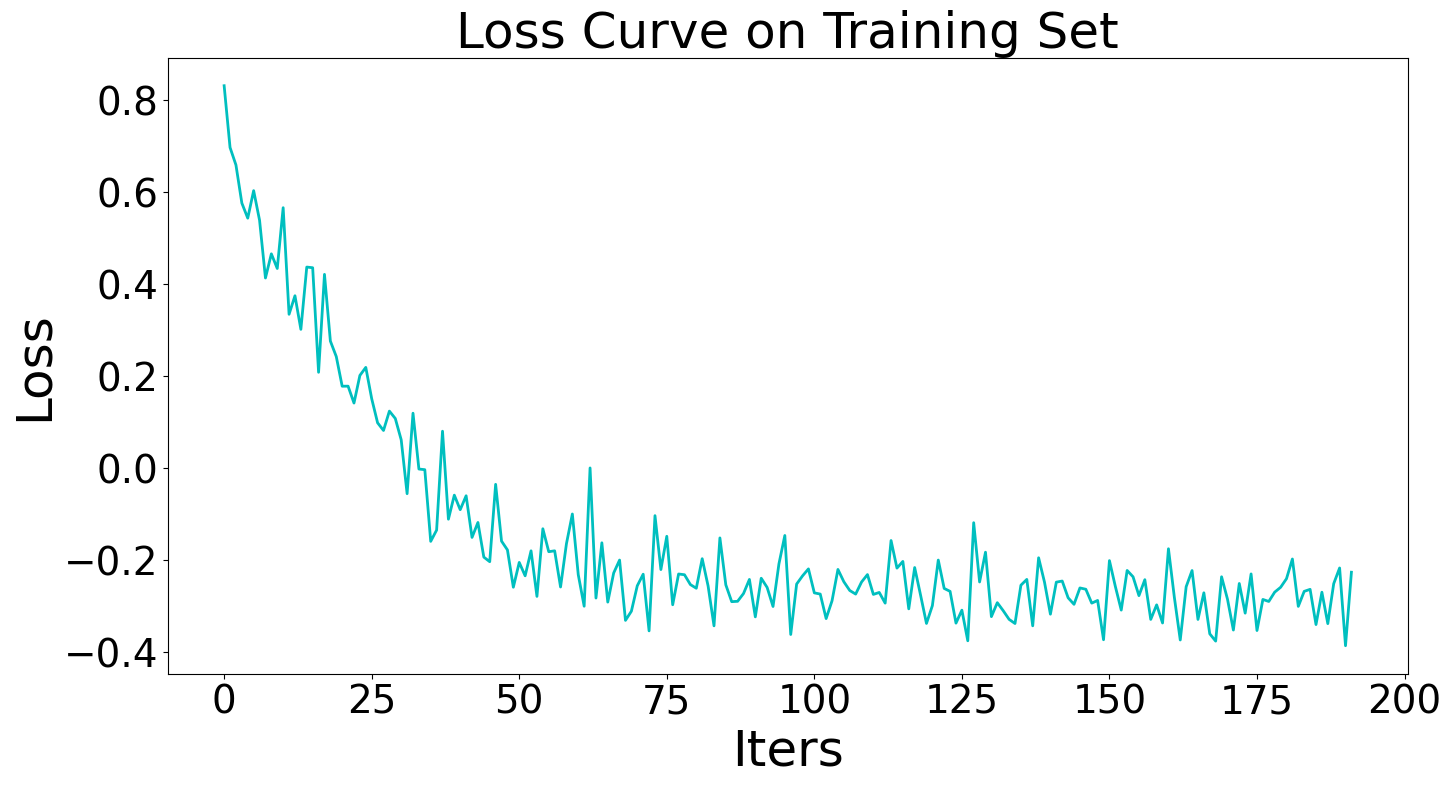

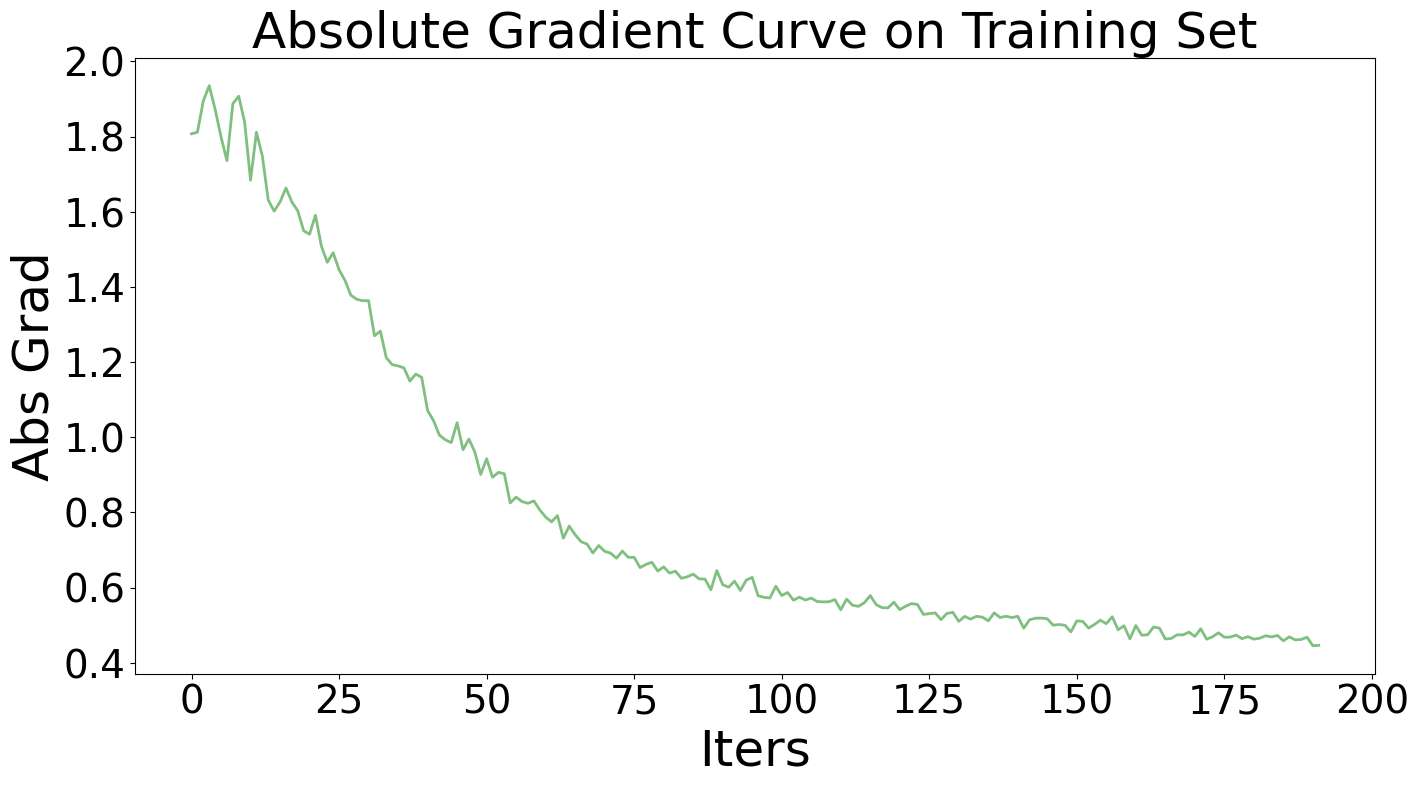

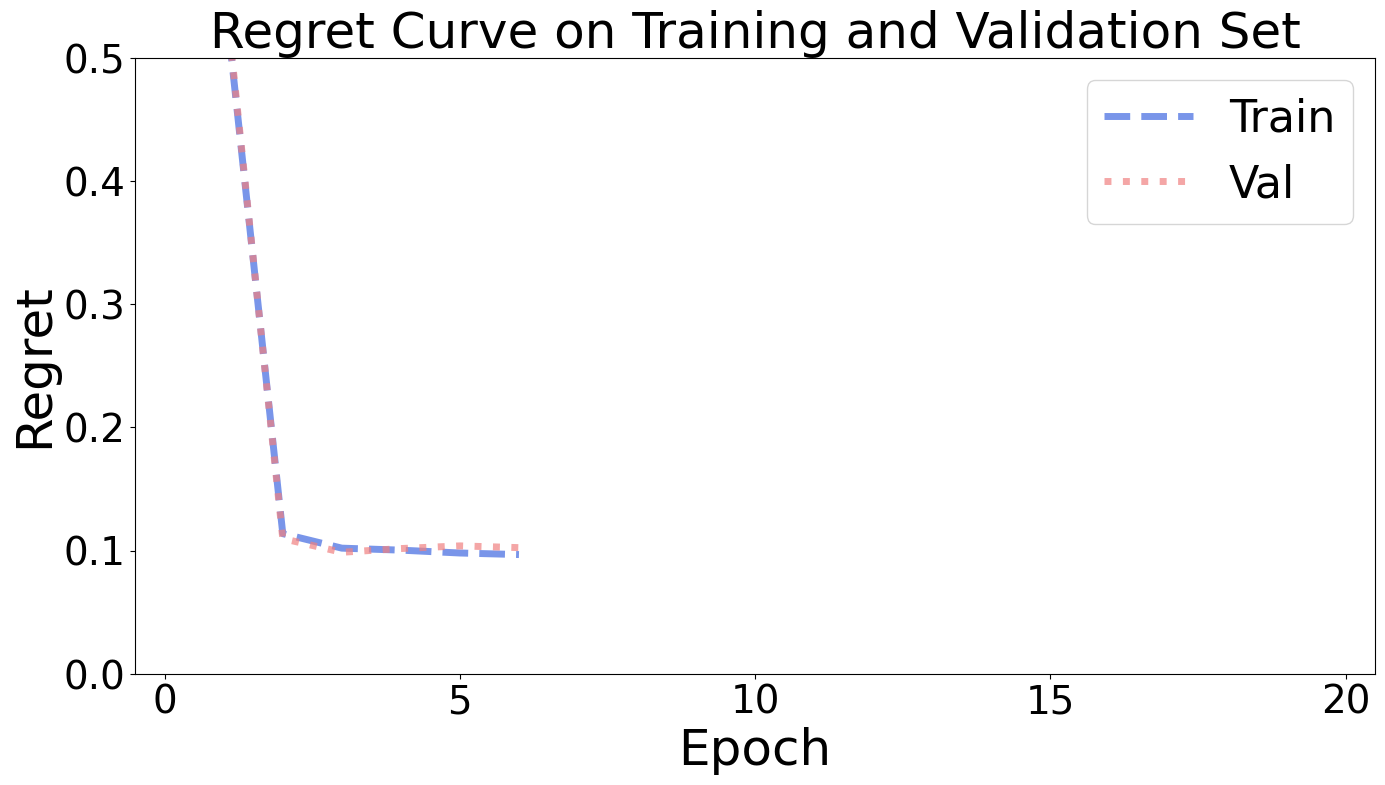

In [31]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

###  Average Method with Cone Check

In [32]:
# init model
reg = LinearRegression()

In [33]:
from func import avgConeAlignedCosine
# init loss
ca_cos = avgConeAlignedCosine(optmodel, check_cone=True)

Num of cores: 1


In [34]:
lr = 1e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:09<?, ?it/s]

Epoch   0, Train Regret: 204.8412%, Val Regret: 214.6115%


Epoch    0, Loss:  -0.0437:   5%|██▊                                                    | 1/20 [00:22<04:16, 13.53s/it]

Epoch   1, Train Regret:  54.9060%, Val Regret:  60.4931%


Epoch    1, Loss:  -0.2790:  10%|█████▌                                                 | 2/20 [00:36<04:05, 13.65s/it]

Epoch   2, Train Regret:  11.5521%, Val Regret:  11.6131%


Epoch    2, Loss:  -0.1446:  15%|████████▎                                              | 3/20 [00:50<03:51, 13.64s/it]

Epoch   3, Train Regret:  10.4919%, Val Regret:  10.7111%


Epoch    3, Loss:  -0.1178:  20%|███████████                                            | 4/20 [01:04<03:40, 13.80s/it]

Epoch   4, Train Regret:  10.0047%, Val Regret:   9.8489%


Epoch    4, Loss:  -0.3354:  25%|█████████████▊                                         | 5/20 [01:18<03:28, 13.89s/it]

Epoch   5, Train Regret:   9.8779%, Val Regret:  10.2393%


Epoch    5, Loss:  -0.2261:  30%|████████████████▌                                      | 6/20 [01:32<03:15, 13.99s/it]

Epoch   6, Train Regret:   9.5875%, Val Regret:   9.9283%


Epoch    6, Loss:  -0.3076:  35%|███████████████████▎                                   | 7/20 [01:47<03:20, 15.40s/it]


Epoch   7, Train Regret:   9.2880%, Val Regret:  10.1237%

Early Stop!

Evaluation:
Test Regret: 10.6021%
Training Elapsed Time: 24.17 Sec


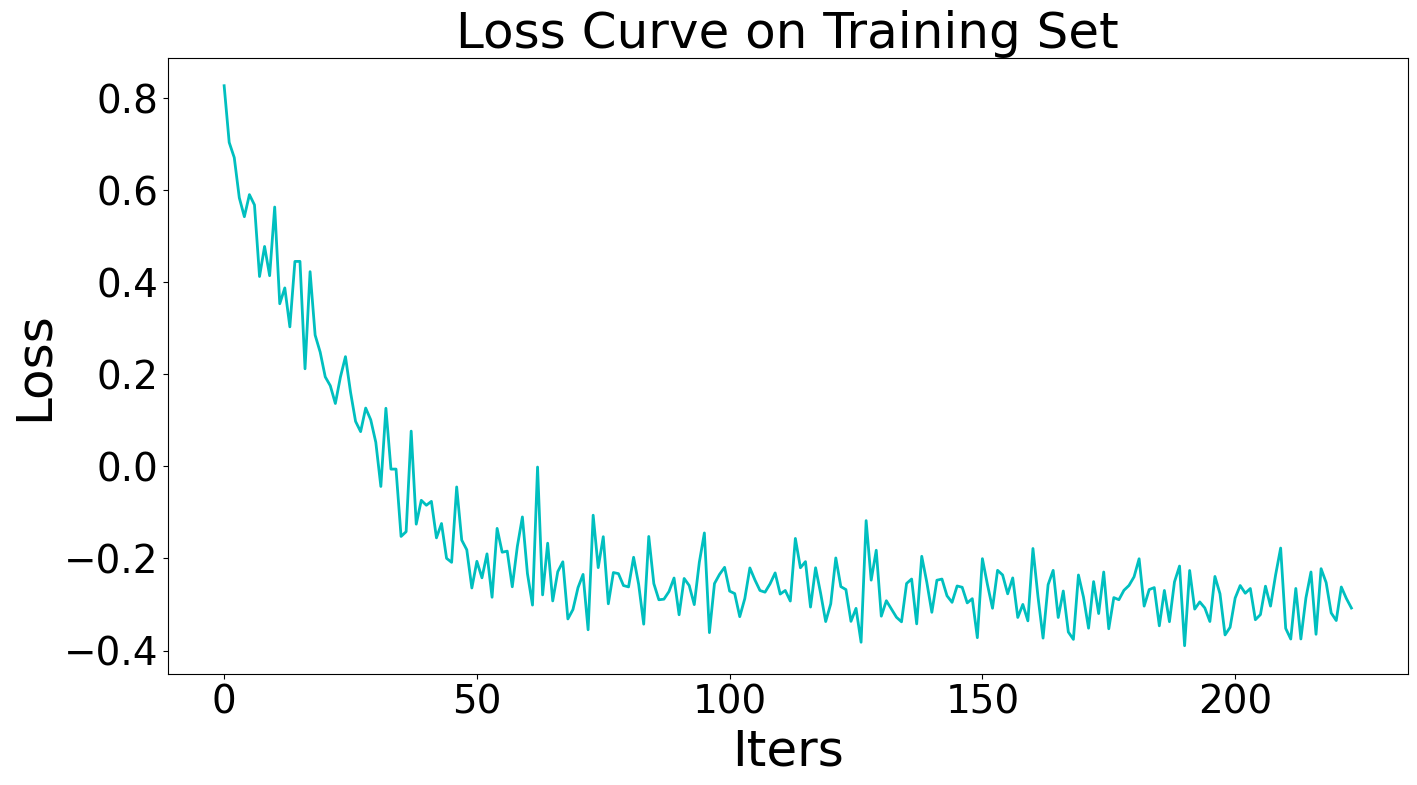

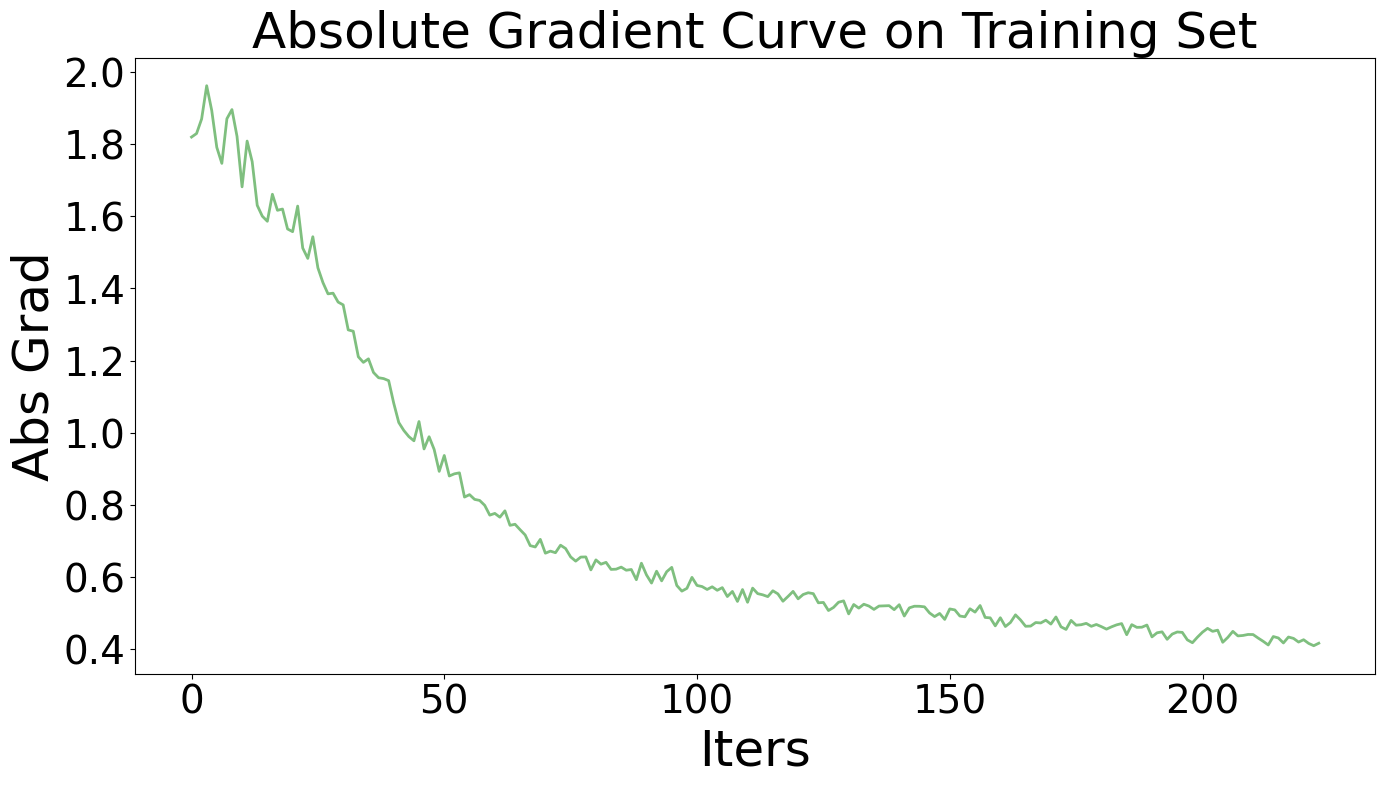

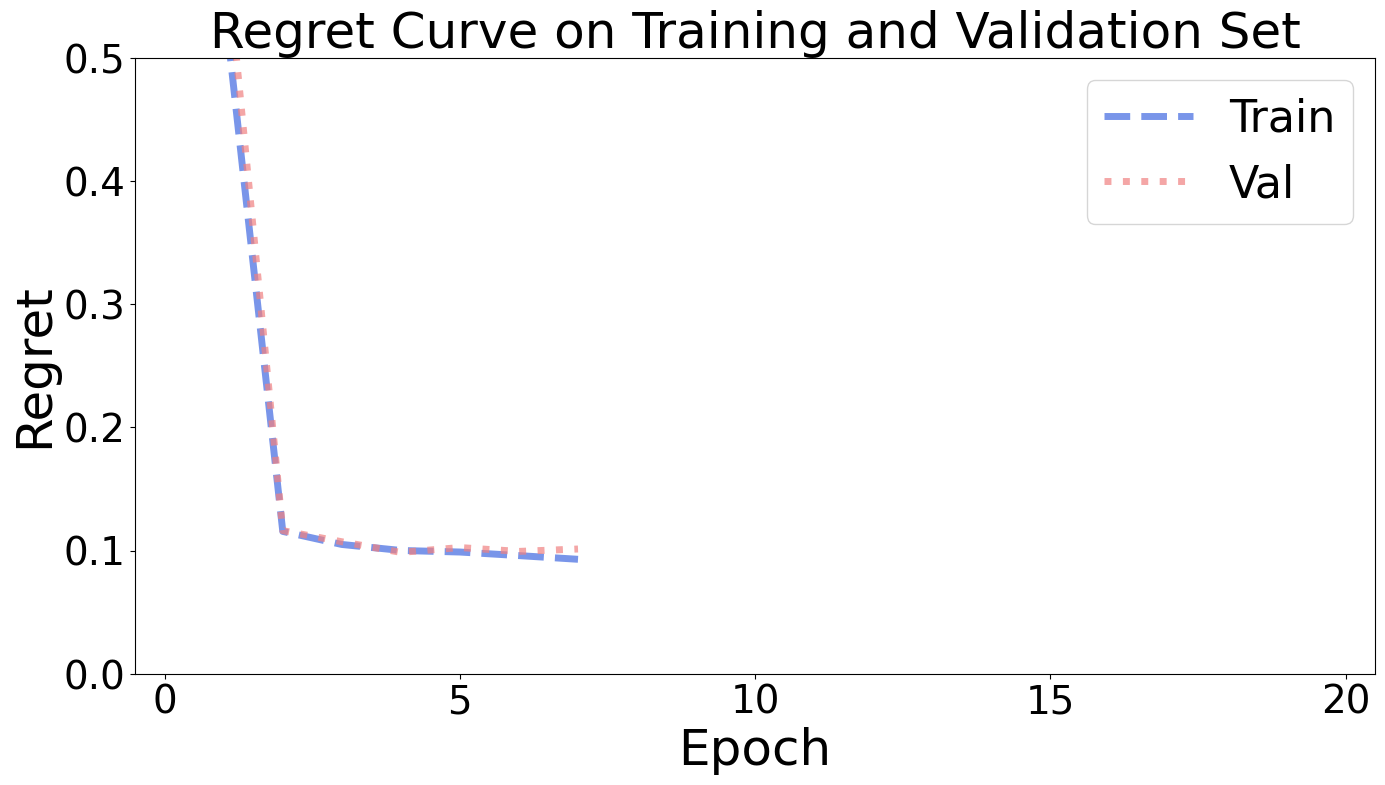

In [35]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)